# Vector Light Fields in a High NA Objective

Start with importing the packages which will be used. One unique package is quadpy. This package made handling the complex valued integration a little easier.

In [ ]:
import numpy as np
from scipy import special
import quadpy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.colors as mcolors

Setup standard parameters

In [2]:
Lambda = 0.5893 # micrometer. Chosen as the Frounhaufer D Line
res = 50 #Provided as 51/53 adjusting will affect run times
NA = 0.9 #Given by prompt. XZ has said High NA > 0.6.
f = 1000 # focal length of the objective in [µm];
pol_angle = .0001 #Used to calculate varpi angle. 0-> full radial, 90 -> full azimuthal
l_0 = 1 #the normalization constant for P_theta not super necessary for this simulation

From these all key variables used in the integral provided in the Qiwen Zhan paper may be found. Defining these here allows for different sections of the simulation to be run independently.

In [3]:
k = 2*np.pi/Lambda #wavenumber
theta_max = np.arcsin(NA) #angle of acceptance
theta = np.linspace(0,theta_max,201)
w = f*np.sin(theta_max) #radius of the beam waist
varphi0 = pol_angle/180*np.pi #defines incident polarization
z = 0
coeff = l_0*k
xArray = np.linspace(-2,2,(res+1))*Lambda
yArray = np.linspace(-2.1,2.1,(res+3))*Lambda
zArray = np.linspace(-4,4,res+1)*Lambda
rArray = np.linspace(-4.1,4.1,res+3)*Lambda 

P_theta = lambda theta: np.exp(-(f*np.sin(theta)/w)**2), # LG00 profile

In order to help keep all of the following simulations modular, a few things related to plotting are defined. Code for keeping the color bars in place, and illustradted better was borrowed from Joseph Longs article on fixing color bars [https://joseph-long.com/writing/colorbars/] In order to create plots with  customized color maps code was borrowed from Kerry Halupka [https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72]

In [4]:
interp = 'gaussian'
space = 0.5

x = xArray[0]/Lambda
y = yArray[0]/Lambda
z = zArray[0]/Lambda
r = rArray[0]/Lambda

#Code borrowed from Joseph Long
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

def hex_to_rgb(value):

    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):

    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))

    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

## Variation of The Incident Beam Profile

First, the necessary values will be adjusted from base parameters which have already been difined. Three different beams will be tested in this simulation. The LG$_{00}$, and LG$_{10}$ modes of the Laguerre-Guassian $lm$ modes, and a Bessel-Gaussian which has been selected to have 3 distinct peaks. It will also be necessary to increase the plotted range for this set of simulations as the Bessel-Gaussian field requires a larger area of interest.

In [5]:
P_theta = [lambda theta: np.exp(-(f*np.sin(theta)/w)**2), # LG00 profile
           lambda theta:(2*f/w*np.sin(theta))*np.exp((-(f*np.sin(theta)/w)**2))*np.sqrt(np.cos(theta))/np.max((2*f/w*np.sin(theta))*np.exp((-(f*np.sin(theta)/w)**2))*np.sqrt(np.cos(theta))),# LG10 profile
           lambda theta:((special.jv(1, 1/36*f*np.sin(theta))*(np.exp((-(f*np.sin(theta)/w)**2)))*np.sqrt(np.cos(theta))))/np.max((special.jv(1, 1/36*f*np.sin(theta))*(np.exp((-(f*np.sin(theta)/w)**2)))*np.sqrt(np.cos(theta))))] #Bessel profile given in handout

BeamResults = ['']*18
xArray = np.linspace(-8,8,(res+1))*Lambda
yArray = np.linspace(-8.1,8.1,(res+3))*Lambda
zArray = np.linspace(-16,16,res+1)*Lambda
rArray = np.linspace(-16.1,16.1,res+3)*Lambda

In [6]:
for i in range(3):
    funr = lambda theta,r,z: (P_theta[i](theta)*np.cos(theta)*np.sin(theta)*special.jv(1,k*r*np.sin(theta))*np.exp(1j*k*z*np.cos(theta)))
    funphi = lambda theta,r,z: (P_theta[i](theta)*np.sin(theta)*special.jv(1,k*r*np.sin(theta))*np.exp(1j*k*z*np.cos(theta)))
    funz = lambda theta,r,z: (P_theta[i](theta)*np.cos(theta)*np.sin(theta**2)*special.jv(0,k*r*np.sin(theta))*np.exp(1j*k*z*np.cos(theta)))

    z=0

    I_phi = np.zeros((len(xArray),len(yArray)), dtype = complex)
    I_r = np.zeros((len(xArray),len(yArray)), dtype = complex)
    I_z = np.zeros((len(xArray),len(yArray)), dtype = complex)

    for l in range(len(xArray)):

        for m in range(len(yArray)):
            r = np.sqrt(xArray[l]**2+yArray[m]**2)
            I_r[l,m] = quadpy.quad(lambda t: funr(t,r,z), 0, theta_max)[0]
            I_phi[l,m] = quadpy.quad(lambda t: funphi(t,r,z), 0, theta_max)[0]
            I_z[l,m] = quadpy.quad(lambda t: funz(t,r,z), 0, theta_max)[0]
    
    BeamResults[6*i+0] = np.abs(coeff*np.cos(varphi0)*np.real_if_close(I_r))**2 #E_rxy^2;
    BeamResults[6*i+1] = np.abs(coeff*np.sin(varphi0)*np.real_if_close(I_phi))**2 #E_phixy^2
    BeamResults[6*i+2] = np.abs(1j*coeff*np.cos(varphi0)*np.real_if_close(I_z))**2#E_zxy^2

    for l in range(len(zArray)):
        z = zArray[l]

        for m in range(len(rArray)):
            r = rArray[m]
            I_r[l,m] = quadpy.quad(lambda t: funr(t,r,z), 0, theta_max)[0]
            I_phi[l,m] = quadpy.quad(lambda t: funphi(t,r,z), 0, theta_max)[0]
            I_z[l,m] = quadpy.quad(lambda t: funz(t,r,z), 0, theta_max)[0]

    BeamResults[6*i+3] = np.transpose(np.abs(coeff*np.cos(varphi0)*np.real_if_close(I_r))**2)#E_rrz^2
    BeamResults[6*i+4] = np.transpose(np.abs(coeff*np.sin(varphi0)*np.real_if_close(I_phi))**2)#E_phirz^2
    BeamResults[6*i+5] = np.transpose(np.abs(1j*coeff*np.cos(varphi0)*np.real_if_close(I_z))**2)#E_zrz^2

With the simulation complete, it is neccessary to return to the initial parameters.

In [7]:
funr = lambda theta,r,z: (P_theta[0](theta)*np.cos(theta)*np.sin(theta)*special.jv(1,k*r*np.sin(theta))*np.exp(1j*k*z*np.cos(theta)))
funphi = lambda theta,r,z: (P_theta[0](theta)*np.sin(theta)*special.jv(1,k*r*np.sin(theta))*np.exp(1j*k*z*np.cos(theta)))
funz = lambda theta,r,z: (P_theta[0](theta)*np.cos(theta)*np.sin(theta**2)*special.jv(0,k*r*np.sin(theta))*np.exp(1j*k*z*np.cos(theta)))

xArray = np.linspace(-2,2,(res+1))*Lambda
yArray = np.linspace(-2.1,2.1,(res+3))*Lambda
zArray = np.linspace(-4,4,res+1)*Lambda
rArray = np.linspace(-4.1,4.1,res+3)*Lambda

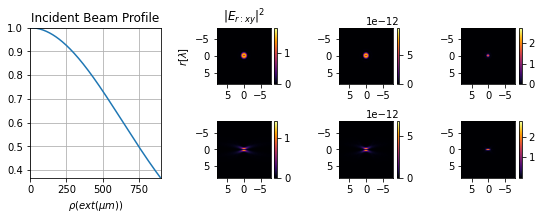

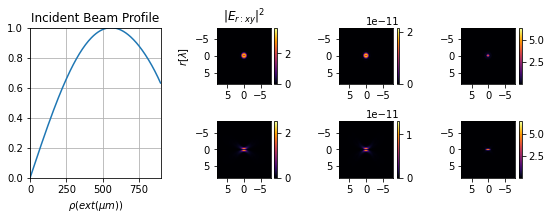

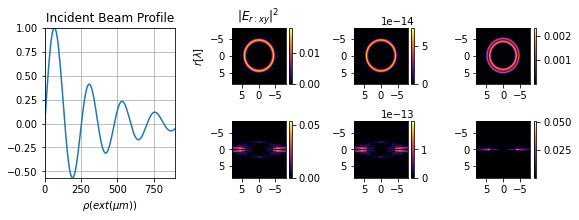

In [16]:
Titles = ['LG00', 'LG01', 'Bessel']
for i in range(3):
    fields = plt.figure(figsize = [9,3])
    
    gs0 = gridspec.GridSpec(1, 2, width_ratios=[2, 5])
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
    
    ax0 = plt.Subplot(fields, gs00[:, :])
    im0 = ax0.plot(f*np.sin(theta),P_theta[i](theta))
    ax0.set(xlabel='$\\rho (\text(μm))$', title='Incident Beam Profile',
            xlim = (0,f*.9), ylim = (np.min(P_theta[i](theta)),1)),

    ax0.grid(), 
    fields.add_subplot(ax0)
    
    
    gs01 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[1], 
                                            wspace = space, hspace = space*1.3)
    plt.subplots_adjust(top=.82)
    ax1 = plt.Subplot(fields, gs01[0, 0])
    
    im1 = ax1.imshow(BeamResults[6*i+0], cmap = 'inferno',
                     extent=[-x*4, x*4, -y*4, y*4], interpolation = interp)
    colorbar(im1)
    ax1.set_title('$|E_{r:xy}|^2$'), ax1.set_ylabel('$r [\lambda]$')
    fields.add_subplot(ax1)
    
    ax2 = plt.Subplot(fields, gs01[0, 1])
    im2 = ax2.imshow(BeamResults[6*i+1], cmap = 'inferno', 
                     extent=[-x*4, x*4, -y*4, y*4], interpolation = interp)
    colorbar(im2)
    ax2.set_title('$|E_{\phi:xy}|^2$')
    fields.add_subplot(ax2)
    
    ax3 = plt.Subplot(fields, gs01[0, 2])
    im3 = ax3.imshow(BeamResults[6*i+2], cmap = 'inferno', 
                     extent=[-x*4, x*4, -y*4, y*4], interpolation = interp)
    colorbar(im3)
    ax3.set(title='$|E_{z:xy}|^2$')
    fields.add_subplot(ax3)
    
    ax4 = plt.Subplot(fields, gs01[1, 0])
    im4 = ax4.imshow(BeamResults[6*i+3], cmap = 'inferno', 
                     extent=[-x*4, x*4, -y*4, y*4], interpolation = interp)
    colorbar(im4)
    ax4.set(title='$|\\textbf{E}_{r:zr}^2|$', xlabel='$z [\lambda]$', 
            ylabel = '$r [\lambda]$')
    fields.add_subplot(ax4)
    
    ax5 = plt.Subplot(fields, gs01[1, 1])
    im5 = ax5.imshow(BeamResults[6*i+4], 
                     cmap = 'inferno', 
                     extent=[-x*4, x*4, -y*4, y*4], interpolation = interp)
    colorbar(im5)
#    ax5.set(title='$|\\textbf{E}_{\phi:zr}^2|$', xlabel='$z [\lambda]$')
    fields.add_subplot(ax5)
    
    ax6 = plt.Subplot(fields, gs01[1, 2])
    im6 = ax6.imshow(BeamResults[6*i+5], cmap = 'inferno', 
                     extent=[-x*4, x*4, -y*4, y*4], interpolation = interp)
    colorbar(im6)
#    ax6.set(title='$|\\textbf{E}_{z:zr}^2|$', xlabel='$z [\lambda]$')
    fields.add_subplot(ax6)
    
#    plt.suptitle("Field Intensity for "+Titles[i]+" Beam")
    plt.show()
    

## Variations of Wavelength

Wavelength is adjusted across the optical range which has been estimated from 400 μm to 700 μm. Again the first step will be to change the variables crucial to this simimulation.

In [ ]:
LambdaResults = np.zeros([11,13])
LambdaResults[0:11, 0] = np.linspace(0.4, 0.7, 11)
LamFields = ['']*11

With the new variables declared the simulation will be run eleven times with the the returned values for the fields stored in the LamFields array, and the standard deviation and average of eacj field, which will be used for comparing the fields, is in the LambdaResults array.

In [ ]:
for i in range(len(LambdaResults)):
    Lambda = LambdaResults[i,0]
    k = 2*np.pi/Lambda
    coeff = l_0*k
    z=0

    for l in range(len(xArray)):

        for m in range(len(yArray)):
            r = np.sqrt(xArray[l]**2+yArray[m]**2)
            I_r[l,m] = quadpy.quad(lambda t: funr(t,r,z), 0, theta_max)[0]
            I_phi[l,m] = quadpy.quad(lambda t: funphi(t,r,z), 0, theta_max)[0]
            I_z[l,m] = quadpy.quad(lambda t: funz(t,r,z), 0, theta_max)[0]

    E_rxy = coeff*np.cos(varphi0)*np.real_if_close(I_r)
    E_phixy = coeff*np.sin(varphi0)*np.real_if_close(I_phi)
    E_zxy = 1j*coeff*np.cos(varphi0)*np.real_if_close(I_z)

    for l in range(len(zArray)):
        z=zArray[l]

        for m in range(len(rArray)):
            r=rArray[m]
            I_r[l,m] = quadpy.quad(lambda t: funr(t,r,z), 0, theta_max)[0]
            I_phi[l,m] = quadpy.quad(lambda t: funphi(t,r,z), 0, theta_max)[0]
            I_z[l,m] = quadpy.quad(lambda t: funz(t,r,z), 0, theta_max)[0]

    E_rrz = coeff*np.cos(varphi0)*np.real_if_close(I_r)
    E_phirz = coeff*np.sin(varphi0)*np.real_if_close(I_phi)
    E_zrz = 1j*coeff*np.cos(varphi0)*np.real_if_close(I_z)
    
    LamFields[i] = np.abs(E_rxy)**2
    
    LambdaResults[i,1] = np.std(np.abs(E_rxy)**2)
    LambdaResults[i,2] = np.std(np.abs(E_phixy)**2)
    LambdaResults[i,3] = np.std(np.abs(E_zxy)**2)
    LambdaResults[i,4] = np.std(np.abs(E_rrz)**2)
    LambdaResults[i,5] = np.std(np.abs(E_phirz)**2)
    LambdaResults[i,6] = np.std(np.abs(E_zrz)**2)
    LambdaResults[i,7] = np.average(np.abs(E_rxy)**2)
    LambdaResults[i,8] = np.average(np.abs(E_phixy)**2)
    LambdaResults[i,9] = np.average(np.abs(E_zxy)**2)
    LambdaResults[i,10] = np.average(np.abs(E_rrz)**2)
    LambdaResults[i,11] = np.average(np.abs(E_phirz)**2)
    LambdaResults[i,12] = np.average(np.abs(E_zrz)**2)

Again it is necessary to return to the original parameters to keep the simulations modular.

In [ ]:
Lambda = 0.5893
k = 2*np.pi/Lambda
coeff = l_0*k

### Plotting of the Results

First, three representative fields are plotted to establish a base line of what aspects of the field are changing as a result of the changes to wavelength. 

In [ ]:
#%%Draw Plots for Changes in Wavelength    
hex_list = [('#000000', '#8300b5'), ('#000000', '#a3ff00'), ('#000000', '#ff0000')]
             
for i in range(3):
    LamField = plt.imshow(LamFields[i*5], cmap = get_continuous_cmap(hex_list[i]), 
                         extent=[-x, x, -y, y], interpolation = interp)
    colorbar(LamField)
    plt.title('$|E_{r:xy}|^2$') 
    plt.ylabel('$r [\lambda]$')
    plt.xlabel('$z [\lambda]$')
    plt.show()

From above it is obvious that the field is more spread across the area of interest at the longer wavlengths. It should also be noted that the peak intensity is also lower with longer wavelengths. In order to further illustrate this trend, the standard deviation and average of the field is plotted bellow

In [ ]:
#Plot Change in STD of Field Intensity for Wavelength 
xlabel = 'Wavelength [µm]'
ylabel = 'Std.'

LamStd = plt.figure(figsize = [9, 6])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[0],
                                        hspace = space, wspace = space)

plt.suptitle("Std. of Field Intensity with Variation in Wavelength")

ax0 = plt.Subplot(LamStd, gs00[0, 0])
im0 = ax0.plot(LambdaResults[0:11, 0], LambdaResults[0:11, 1])
ax0.set(title='|E$_{r:xy}|^2$', ylabel = ylabel), 
ax0.grid(), 
LamStd.add_subplot(ax0)

ax1 = plt.Subplot(LamStd, gs00[0, 1])
im1 = ax1.plot(LambdaResults[0:11, 0],LambdaResults[0:11, 2])
ax1.set(title='|E$_{\phi:xy}|^2$'), ax1.grid(), 
LamStd.add_subplot(ax1)

ax2 = plt.Subplot(LamStd, gs00[0, 2])
im2 = ax2.plot(LambdaResults[0:11, 0],LambdaResults[0:11, 3])
ax2.set(title='|E$_{z:xy}|^2$'), ax2.grid(), 
LamStd.add_subplot(ax2)

ax3 = plt.Subplot(LamStd, gs00[1, 0])
im3 = ax3.plot(LambdaResults[0:11, 0],LambdaResults[0:11, 4])
ax3.set(title='|E$_{r:zr}^2|$', xlabel = xlabel, ylabel = ylabel), ax3.grid(), 
LamStd.add_subplot(ax3)

ax4 = plt.Subplot(LamStd, gs00[1, 1])
im4 = ax4.plot(LambdaResults[0:11, 0],LambdaResults[0:11, 5])
ax4.set(title='|E$_{\phi:zr}^2|$',  xlabel = xlabel), ax4.grid(), 
LamStd.add_subplot(ax4)

ax5 = plt.Subplot(LamStd, gs00[1, 2])
im5 = ax5.plot(LambdaResults[0:11, 0],LambdaResults[0:11, 6])
ax5.set(title='|E$_{z:zr}^2|$', xlabel = xlabel), ax5.grid(), 
LamStd.add_subplot(ax5)

#LamStd.tight_layout()

#Plot Change in Std of Field Intensity for Wavelength 
xlabel = 'Wavelength [µm]'
ylabel = 'Average'

LamAvg = plt.figure(figsize = [9, 6])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[0],
                                        hspace = space, wspace = space)

plt.suptitle("Average Field Intensity with Variation in Wavelength")

ax0 = plt.Subplot(LamAvg, gs00[0, 0])
im0 = ax0.plot(LambdaResults[0:11, 0], LambdaResults[0:11, 7])
ax0.set(title='|E$_{r:xy}|^2$', ylabel = ylabel), 
ax0.grid(), 
LamAvg.add_subplot(ax0)

ax1 = plt.Subplot(LamAvg, gs00[0, 1])
im1 = ax1.plot(LambdaResults[0:11, 0],LambdaResults[0:11, 8])
ax1.set(title='|E$_{\phi:xy}|^2$'), ax1.grid(), 
LamAvg.add_subplot(ax1)

ax2 = plt.Subplot(LamAvg, gs00[0, 2])
im2 = ax2.plot(LambdaResults[0:11, 0],LambdaResults[0:11, 9])
ax2.set(title='|E$_{z:xy}|^2$'), ax2.grid(), 
LamAvg.add_subplot(ax2)

ax3 = plt.Subplot(LamAvg, gs00[1, 0])
im3 = ax3.plot(LambdaResults[0:11, 0],LambdaResults[0:11, 10])
ax3.set(title='|E$_{r:zr}^2|$', xlabel = xlabel, ylabel = ylabel), ax3.grid(), 
LamAvg.add_subplot(ax3)

ax4 = plt.Subplot(LamAvg, gs00[1, 1])
im4 = ax4.plot(LambdaResults[0:11, 0],LambdaResults[0:11, 11])
ax4.set(title='|E$_{\phi:zr}^2|$',  xlabel = xlabel), ax4.grid(), 
LamAvg.add_subplot(ax4)

ax5 = plt.Subplot(LamAvg, gs00[1, 2])
im5 = ax5.plot(LambdaResults[0:11, 0],LambdaResults[0:11, 12])
ax5.set(title='|E$_{z:zr}^2|$', xlabel = xlabel), ax5.grid(), 
LamAvg.add_subplot(ax5)

#LamAvg.tight_layout()

plt.savefig(fname = 'LamAvg.pdf', bbox_inches = 'tight', format = 'pdf')
plt.savefig(fname = 'LamAvg', bbox_inches = 'tight')
plt.show()

Observations

## Variation of Polarization

As always the first stup will be to setup the parameters which will be changing durng the simulation as well as prealocate the memory. For investigations into the affect of cahanges in polarization is is sensible to choose the range for $\varphi_0$ to be from  0$^\circ$ to 90$^\circ$. In other words from full radial polarization, to full azimuthal. One challenge to this is that at 0$^\circ$ the $E_r, E_z$ fields will go to zero and at 90$^\circ$ the $E_\phi$ field will go to 0. In the interest of being able to produce plots across the full range, these conditions have been approximated.

In [ ]:
PolResults = np.zeros([11,13])
PolResults[0:11, 0] = np.linspace(0.0001, 89.9999, 11)
PolFields = ['']*11
FieldResults = ['']*22

As before the simulation will be repeated eleven times with the data for the fields going into the PolFields array, and the standard deviation and sum of each of those fields going into the FieldResults array.

In [ ]:
for i in range(len(PolResults)):

    varphi0 = PolResults[i,0]/180*np.pi

    z=0

    phi = np.zeros((len(xArray),len(yArray)))
    I_phi2 = np.zeros((len(xArray),len(yArray)), dtype = complex)
    I_r2 = np.zeros((len(xArray),len(yArray)), dtype = complex)

    for l in range(len(xArray)):

        for m in range(len(yArray)):
            r = np.sqrt(xArray[l]**2+yArray[m]**2)
            I_r[l,m] = (quadpy.quad(lambda t: funr(t,r,z), 0, theta_max)[0])
            I_phi[l,m] = (quadpy.quad(lambda t: funphi(t,r,z), 0, theta_max)[0])
            I_z[l,m] = (quadpy.quad(lambda t: funz(t,r,z), 0, theta_max)[0])
            phi[l,m] = (np.arctan2(yArray[m], xArray[l]))
 
            phi[l,m] = (np.arctan2(yArray[m], xArray[l]))
            I_phi2[l,m] = (quadpy.quad(lambda t: funphi(t,r,z), 0, theta_max)[0])
            I_r2[l,m] = (quadpy.quad(lambda t: funr(t,r,z), 0, theta_max)[0])

    E_rxy = coeff*np.cos(varphi0)*np.real_if_close(I_r)
    E_phixy = coeff*np.sin(varphi0)*np.real_if_close(I_phi)
    E_zxy = 1j*coeff*np.cos(varphi0)*np.real_if_close(I_z)
    
    E_phixy2 = coeff*np.sin(varphi0)*np.real_if_close(I_phi2)
    E_rxy2 = coeff*np.cos(varphi0)*np.real_if_close(I_r2)
    FieldResults[2*i+0] = np.cos(phi)*E_rxy2-np.sin(phi)*E_phixy2#Ex
    FieldResults[2*i+1] = np.sin(phi)*E_rxy2+np.cos(phi)*E_phixy2#Ey
    
    for l in range(len(zArray)):
        z = zArray[l]

        for m in range(len(rArray)):
            r = rArray[m]
            I_r[l,m] = (quadpy.quad(lambda t: funr(t,r,z), 0, theta_max)[0])
            I_phi[l,m] = (quadpy.quad(lambda t: funphi(t,r,z), 0, theta_max)[0])
            I_z[l,m] = (quadpy.quad(lambda t: funz(t,r,z), 0, theta_max)[0])

    E_rrz = coeff*np.cos(varphi0)*np.real_if_close(I_r)
    E_phirz = coeff*np.sin(varphi0)*np.real_if_close(I_phi)
    E_zrz = 1j*coeff*np.cos(varphi0)*np.real_if_close(I_z)
    
    PolFields[i] = np.abs(E_rxy)**2
    
    PolResults[i,1] = np.std(np.abs(E_rxy)**2)
    PolResults[i,2] = np.std(np.abs(E_phixy)**2)
    PolResults[i,3] = np.std(np.abs(E_zxy)**2)
    PolResults[i,4] = np.std(np.abs(E_rrz)**2)
    PolResults[i,5] = np.std(np.abs(E_phirz)**2)
    PolResults[i,6] = np.std(np.abs(E_zrz)**2)
    PolResults[i,7] = np.average(np.abs(E_rxy)**2)
    PolResults[i,8] = np.average(np.abs(E_phixy)**2)
    PolResults[i,9] = np.average(np.abs(E_zxy)**2)
    PolResults[i,10] = np.average(np.abs(E_rrz)**2)
    PolResults[i,12] = np.average(np.abs(E_phirz)**2)
    PolResults[i,11] = np.average(np.abs(E_zrz)**2)

Before moving forward the variables are reurned to their standard values.

In [ ]:
pol_angle = .0001
varphi0 = pol_angle/180*np.pi

### Plotting of the Results

Again representative plots of $|\textbf{E}_{r:xy}|^2$ are created in order to get an idea of the affect that these changes had.

In [ ]:
for i in range(3):
    PolField = plt.imshow(PolFields[i*5], cmap = 'inferno', 
                         extent=[-x, x, -y, y], 
                                 interpolation = interp)
    colorbar(PolField)
    plt.title('|E$_{r:xy}|^2$') 
    plt.ylabel('$r [\lambda]$')
    plt.xlabel('$z [\lambda]$')
    plt.show()

As may have been expected the affect to the polarization is that the field here is high for the fully radial 0$^\circ$ condition and much lower for the fully azimuthal 90$^\circ$ condition. It may also be observed that the field is not spreading out as was the case when \lambda had been varied. To further investigate this, again the standard deviation of the field is again plotted.

In [ ]:
#Plot Change in Std of Field Intensity for Polarization 
xlabel = 'Angle [$^\circ$]'
ylabel = 'Std.'

PolStd = plt.figure(figsize = [9, 6])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[0],
                                        hspace = space, wspace = space)

plt.suptitle("Std. of Field Intensity with Variation in Polarization")

ax0 = plt.Subplot(PolStd, gs00[0, 0])
im0 = ax0.plot(PolResults[0:11, 0], PolResults[0:11, 1])
ax0.set(title='$|E$_{r:xy}|^2$', ylabel = ylabel), 
ax0.grid(), 
PolStd.add_subplot(ax0)

ax1 = plt.Subplot(PolStd, gs00[0, 1])
im1 = ax1.plot(PolResults[0:11, 0],PolResults[0:11, 2])
ax1.set(title='$|E$_{\phi:xy}|^2$'), ax1.grid(), 
PolStd.add_subplot(ax1)

ax2 = plt.Subplot(PolStd, gs00[0, 2])
im2 = ax2.plot(PolResults[0:11, 0],PolResults[0:11, 3])
ax2.set(title='$|E$_{z:xy}|^2$'), ax2.grid(), 
PolStd.add_subplot(ax2)

ax3 = plt.Subplot(PolStd, gs00[1, 0])
im3 = ax3.plot(PolResults[0:11, 0],PolResults[0:11, 4])
ax3.set(title='$|E$_{r:zr}^2|$', xlabel = xlabel, ylabel = ylabel), ax3.grid(), 
PolStd.add_subplot(ax3)

ax4 = plt.Subplot(PolStd, gs00[1, 1])
im4 = ax4.plot(PolResults[0:11, 0],PolResults[0:11, 5])
ax4.set(title='$|E$_{\phi:zr}^2|$',  xlabel = xlabel), ax4.grid(), 
PolStd.add_subplot(ax4)

ax5 = plt.Subplot(PolStd, gs00[1, 2])
im5 = ax5.plot(PolResults[0:11, 0],PolResults[0:11, 6])
ax5.set(title='$|E$_{z:zr}^2|$', xlabel = xlabel), ax5.grid(), 
PolStd.add_subplot(ax5)

This shows that the main result of the change in incident poloarization is that the energy will become focused to certain planes. This result follows the aformentioned intuitive result based on the value of $\cos \varphi_0$, and $\sin \varphi_0$. It also seems prudent to investigate it the lens had any affect on the polarization of the field. To do this quiver plots are generated for the polarization at the same representative values as before.

In [ ]:
#Plot Transverse Field in Focal Plane
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = [9, 3])
[X,Y] = np.meshgrid(xArray/Lambda, yArray/Lambda)
step = 4
plt.subplots_adjust(top=.85)
plt.suptitle('Plarization in the Focal Region for Various Incident Polarizations ($\Re[\\textbf{E}_x,\\textbf{E}_y])$')

axs[0].set(title='Full Radial ($\\varphi \\approx \SI{0}{\degree}$)', xlabel='z $[\lambda]$', ylabel = 'r $[\lambda]$')
axs[0].quiver(X[::step, ::step], Y[::step, ::step],
              np.real(np.transpose(FieldResults[0]))[::step, ::step], 
              np.real(np.transpose(FieldResults[1]))[::step, ::step])

axs[1].set(title='Equal Polarization ($\\varphi = \SI{45}{\degree}$)', xlabel='z $[\lambda]$')
axs[1].quiver(X[::step, ::step], Y[::step, ::step],
              np.real(np.transpose(FieldResults[8]))[::step, ::step], 
              np.real(np.transpose(FieldResults[9]))[::step, ::step])

axs[2].set(title='Full Azimuthal ($\\varphi \\approx \SI{90}{\degree}$)', xlabel='z $[\lambda]$')
axs[2].quiver(X[::step, ::step], Y[::step, ::step],
              np.real(np.transpose(FieldResults[-2]))[::step, ::step], 
              np.real(np.transpose(FieldResults[-1]))[::step, ::step])
plt.show()

## Variations of Numerical Aperature

Change variables, prealocate memory

In [ ]:
NAResults = np.zeros([11,13])
NAResults[0:11, 0] = np.linspace(0.6, 0.9, 11)
NAFields = ['']*11

Run the simulation

In [ ]:
for i in range(len(NAResults)):
    NA = NAResults[i,0]
    theta_max = np.arcsin(NA)
    theta = np.linspace(0,theta_max,201)
    w = 0.4*f*np.sin(theta_max)

    z=0

    for l in range(len(xArray)):

        for m in range(len(yArray)):
            r = np.sqrt(xArray[l]**2+yArray[m]**2)
            I_r[l,m] = (quadpy.quad(lambda t: funr(t,r,z), 0, theta_max)[0])
            I_phi[l,m] = (quadpy.quad(lambda t: funphi(t,r,z), 0, theta_max)[0])
            I_z[l,m] = (quadpy.quad(lambda t: funz(t,r,z), 0, theta_max)[0])

    E_rxy = coeff*np.cos(varphi0)*np.real_if_close(I_r)
    E_phixy = coeff*np.sin(varphi0)*np.real_if_close(I_phi)
    E_zxy = 1j*coeff*np.cos(varphi0)*np.real_if_close(I_z)
    
    for l in range(len(zArray)):
        z = zArray[l]

        for m in range(len(rArray)):
            r=rArray[m]
            I_r[l,m] = (quadpy.quad(lambda t: funr(t,r,z), 0, theta_max)[0])
            I_phi[l,m] = (quadpy.quad(lambda t: funphi(t,r,z), 0, theta_max)[0])
            I_z[l,m] = (quadpy.quad(lambda t: funz(t,r,z), 0, theta_max)[0])

    E_rrz = coeff*np.cos(varphi0)*np.real_if_close(I_r)
    E_phirz = coeff*np.sin(varphi0)*np.real_if_close(I_phi)
    E_zrz = 1j*coeff*np.cos(varphi0)*np.real_if_close(I_z)
    
    NAFields[i] = np.abs(E_rxy)**2
    
    NAResults[i,1] = np.std(np.abs(E_rxy)**2)
    NAResults[i,2] = np.std(np.abs(E_phixy)**2)
    NAResults[i,3] = np.std(np.abs(E_zxy)**2)
    NAResults[i,4] = np.std(np.abs(E_rrz)**2)
    NAResults[i,5] = np.std(np.abs(E_phirz)**2)
    NAResults[i,6] = np.std(np.abs(E_zrz)**2)
    NAResults[i,7] = np.sum(np.abs(E_rxy)**2)
    NAResults[i,8] = np.sum(np.abs(E_phixy)**2)
    NAResults[i,9] = np.sum(np.abs(E_zxy)**2)
    NAResults[i,10] = np.sum(np.abs(E_rrz)**2)
    NAResults[i,11] = np.sum(np.abs(E_phirz)**2)
    NAResults[i,12] = np.sum(np.abs(E_zrz)**2)

Return to orgiginal parameters

In [ ]:
NA = 0.9

### Plot the Results

Three representative plots

In [ ]:
for i in range(3):
    NAField = plt.imshow(NAFields[i*5], cmap = 'inferno', 
                         extent=[-x, x, -y, y], 
                                 interpolation = interp)
    colorbar(NAField)
    plt.title('$|\\textbf{E}_{r:xy}|^2$') 
    plt.ylabel('$r [\lambda]$')
    plt.xlabel('$z [\lambda]$')
    plt.show()

Analysis of the plots, and reasoning for next investigation.

In [ ]:
xlabel = '$N.A.$'
ylabel = 'Std.'

NAStd = plt.figure(figsize = [9, 6])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[0],
                                        hspace = space, wspace = space)

plt.suptitle("Std. of Field Intensity with Varying $N.A.$")

ax0 = plt.Subplot(NAStd, gs00[0, 0])
im0 = ax0.plot(NAResults[0:11, 0],NAResults[0:11, 1])
ax0.set(title='$|\\textbf{E}_{r:xy}|^2$', ylabel = ylabel), 
ax0.grid(), 
NAStd.add_subplot(ax0)

ax1 = plt.Subplot(NAStd, gs00[0, 1])
im1 = ax1.plot(NAResults[0:11, 0],NAResults[0:11, 2])
ax1.set(title='$|\\textbf{E}_{\phi:xy}|^2$'), ax1.grid(), 
NAStd.add_subplot(ax1)

ax2 = plt.Subplot(NAStd, gs00[0, 2])
im2 = ax2.plot(NAResults[0:11, 0],NAResults[0:11, 3])
ax2.set(title='$|\\textbf{E}_{z:xy}|^2$'), ax2.grid(), 
NAStd.add_subplot(ax2)

ax3 = plt.Subplot(NAStd, gs00[1, 0])
im3 = ax3.plot(NAResults[0:11, 0],NAResults[0:11, 4])
ax3.set(title='$|\\textbf{E}_{r:zr}^2|$', xlabel = xlabel, ylabel = ylabel), ax3.grid(), 
NAStd.add_subplot(ax3)

ax4 = plt.Subplot(NAStd, gs00[1, 1])
im4 = ax4.plot(NAResults[0:11, 0],NAResults[0:11, 5])
ax4.set(title='$|\\textbf{E}_{\phi:zr}^2|$',  xlabel = xlabel), ax4.grid(), 
NAStd.add_subplot(ax4)

ax5 = plt.Subplot(NAStd, gs00[1, 2])
im5 = ax5.plot(NAResults[0:11, 0],NAResults[0:11, 6])
ax5.set(title='$|\\textbf{E}_{z:zr}^2|$', xlabel = xlabel), ax5.grid(), 
NAStd.add_subplot(ax5)

Analyze the results and justify next investigation.

In [ ]:
volResults = np.zeros([len(NAResults)])
ratResults = np.zeros([len(NAResults),2])
for i in range(len(NAResults)):
    NA = NAResults[i,0]
    theta_max = np.arcsin(NA)
    theta = np.linspace(0,theta_max,201)
    w = 0.4*f*np.sin(theta_max)
    volResults[i] = quadpy.quad(lambda theta: 2*np.pi*theta*np.exp(-(f*np.sin(theta)/w)**2), 0, theta_max)[0]
    ratResults[i] = NAResults[i, 1]/volResults[i], NAResults[i, 7]/volResults[i]

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = [9, 3])
plt.subplots_adjust(top = .85)
plt.suptitle('Comparison of Beam Volume to SD and Sum Intensity of Field Intensity')

axs[0].set(title='Volume of the Beam', xlabel='$N.A.$', )
axs[0].plot(NAResults[0:11, 0], volResults), axs[0].grid()

axs[1].set(title='Standard Deviation', xlabel='$N.A.$')
axs[1].plot(NAResults[0:11, 0], ratResults[0:11,0]), axs[1].grid()

axs[2].set(title='Sum Intensity', xlabel='$N.A.$')
axs[2].plot(NAResults[0:11, 0], ratResults[0:11, 1]), axs[2].grid()

plt.savefig(fname = 'NAVol', bbox_inches = 'tight')
plt.savefig(fname = 'NAVol.pdf', bbox_inches = 'tight', format = 'pdf')
plt.show()

Analyze results

## Conclusions

Conclusions